In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
import scipy.integrate as integrate
import statsmodels.graphics.gofplots as sgg
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity
%matplotlib inline
#%matplotlib tk

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be r

In [2]:
my_data = pd.read_csv('/home/lin/教材/Financial_data/data/Ripple.csv')
my_data['Date']=pd.to_datetime(my_data['Date'])
my_data.set_index('Date', inplace = True)
close = np.flip(my_data['Close'], 0)
volume = my_data['Volume'].dropna()
logR = np.log(close).diff()
logR.drop(logR.index[0], inplace = True)
logR.describe()

count    1618.000000
mean        0.003731
std         0.079982
min        -0.616273
25%        -0.021178
50%        -0.002303
75%         0.021177
max         1.027356
Name: Close, dtype: float64

In [3]:
test_set = logR[-252 :]
training_set = logR[: -252]

In [4]:
posiR = training_set[training_set > 0].dropna()
negaR = training_set[training_set <= 0].dropna()
sortedPosiR = posiR.sort_values()
sortedNegaR = (-negaR).sort_values()
mirrorNegative = sortedNegaR.append(-sortedNegaR)
mirrorPosi = sortedPosiR.append(-sortedPosiR)
numObs = training_set.count()

In [5]:
np.unique(negaR <= 0)

array([ True])

In [6]:
np.unique(posiR > 0)

array([ True])

In [7]:
mu_log = np.mean(training_set)
sigma_log = np.std(training_set)
t_para = stats.t.fit(training_set, loc = mu_log, scale = sigma_log)
posi_t_para = stats.t.fit(mirrorPosi)
nega_t_para = stats.t.fit(mirrorNegative)
gen_para = stats.genextreme.fit(training_set, loc = mu_log, scale = sigma_log)
nega_gen_para = stats.genpareto.fit(sortedNegaR, loc = mu_log, scale = sigma_log)
posi_gen_para = stats.genpareto.fit(sortedPosiR, loc = mu_log, scale = sigma_log)

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2062: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


histgram of whole set plotted with whole set fitted gen extreme, t, normal


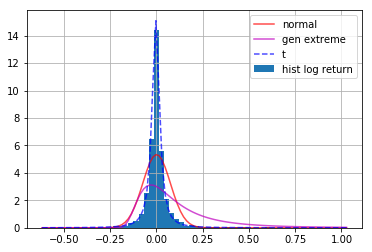

In [8]:
print('histgram of whole set plotted with whole set fitted gen extreme, t, normal')
#%matplotlib inline
#%matplotlib qt
numbins = int(60) 
training_set.hist(bins = numbins, normed=True)

x_ticks = np.linspace(min(training_set), max(training_set),100)
plt.plot(x_ticks, 1./((2.*np.pi)**0.5 *sigma_log)*np.exp(-((x_ticks - mu_log)/sigma_log)**2/2), 'r', alpha = 0.7)
plt.plot(x_ticks, (stats.genextreme.pdf(x_ticks, c =gen_para[0] , loc = gen_para[1], scale = gen_para[2])), 'm', alpha = 0.7)
plt.plot(x_ticks, (stats.t.pdf(x_ticks, df = t_para[0] , loc = t_para[1], scale = t_para[2])), '--b', alpha = 0.7)
plt.legend(['normal', 'gen extreme', 't', 'hist log return'])

loglog halves with whole_gen_extreme and gen_pareto and normal


(0.0004, 1.05)

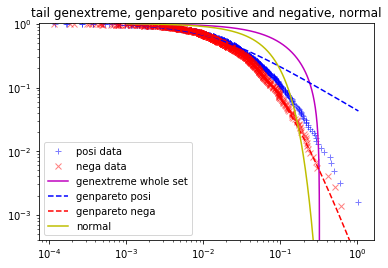

In [9]:
print('loglog halves with whole_gen_extreme and gen_pareto and normal')
plt.figure()
domain = np.linspace(max(abs(training_set))/1000, max(abs(training_set)), 1000)
plt.loglog(sortedPosiR, 1 - (range(1, sortedPosiR.count() + 1))/(sortedPosiR.count() + 1), '+b', alpha = 0.5)
plt.loglog(sortedNegaR, 1 - (range(1, sortedNegaR.count() + 1))/(sortedNegaR.count() + 1), 'xr', alpha = 0.5)
plt.loglog(domain, 1 - (stats.genextreme.cdf(domain, c =gen_para[0] , loc = gen_para[1], scale = gen_para[2]) - 0.365) * 2, 'm')
plt.loglog(domain, 1 - (stats.genpareto.cdf(domain, c =posi_gen_para[0] , loc = posi_gen_para[1], scale = posi_gen_para[2])), '--b')
plt.loglog(domain, 1 - (stats.genpareto.cdf(domain, c =nega_gen_para[0] , loc = nega_gen_para[1], scale = nega_gen_para[2])), '--r')
plt.loglog(domain, 1 - (stats.norm.cdf(domain, mu_log, sigma_log) - 0.5) * 2, 'y')
plt.title('tail genextreme, genpareto positive and negative, normal')
plt.legend(['posi data', 'nega data', 'genextreme whole set', 'genpareto posi', 'genpareto nega', 'normal'], loc = 3)
plt.ylim([4e-4, 1.05])

loglog halves with whole_t and mirror_fitted_t and normal


(0.0001, 1.05)

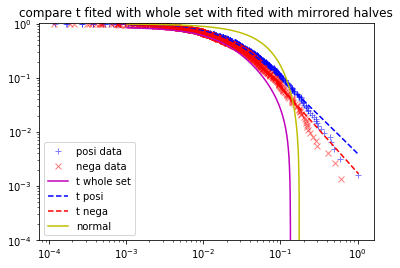

In [10]:
print('loglog halves with whole_t and mirror_fitted_t and normal')

#%matplotlib tk
plt.figure()
domain = np.linspace(max(abs(training_set))/1000, max(abs(training_set)), 1000)
plt.loglog(sortedPosiR, 1 - (range(1, sortedPosiR.count() + 1))/(sortedPosiR.count() + 1), '+b', alpha = 0.5)
plt.loglog(sortedNegaR, 1 - (range(1, sortedNegaR.count() + 1))/(sortedNegaR.count() + 1), 'xr', alpha = 0.5)
plt.loglog(domain, 1 - (stats.t.cdf(domain, df =t_para[0] , loc = t_para[1], scale = t_para[2]) - 0.474) * 2, 'm')
plt.loglog(domain, 1 - (stats.t.cdf(domain, df =posi_t_para[0] , loc = posi_t_para[1], scale = posi_t_para[2]) - 0.5) * 2, '--b')
plt.loglog(domain, 1 - (stats.t.cdf(domain, df =nega_t_para[0] , loc = nega_t_para[1], scale = nega_t_para[2]) - 0.5) * 2, '--r')

plt.loglog(domain, 1 - (stats.norm.cdf(domain, mu_log, sigma_log) - 0.49) * 2, 'y')
plt.title('compare t fited with whole set with fited with mirrored halves')
plt.legend(['posi data', 'nega data', 't whole set', 't posi', 't nega', 'normal'])
plt.ylim([1e-4, 1.05])

histgram of whole set plotted with whole set fitted t, mirror_fitted_t, and halves with gen pareto


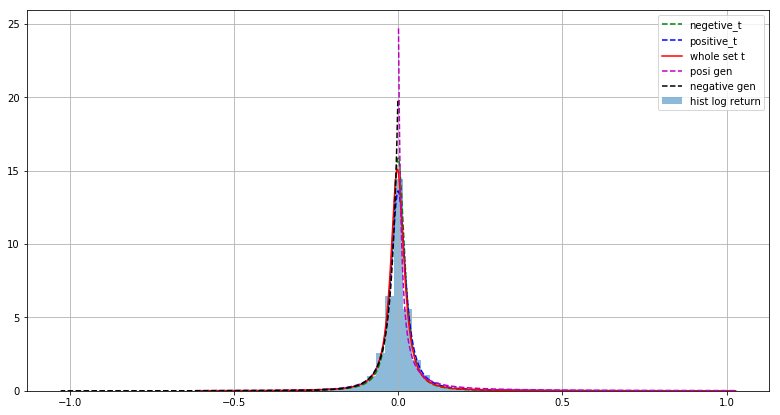

In [11]:
print('histgram of whole set plotted with whole set fitted t, mirror_fitted_t, and halves with gen pareto')
%matplotlib tk
numbins = int(60) 
training_set.hist(bins = numbins, normed=True, alpha = 0.5)
x_ticks = np.linspace(min(training_set), max(abs(training_set)),2000)
plt.plot(x_ticks, (stats.t.pdf(x_ticks, df = nega_t_para[0] , loc = nega_t_para[1], scale = nega_t_para[2])), '--g')
plt.plot(x_ticks, (stats.t.pdf(x_ticks, df = posi_t_para[0] , loc = posi_t_para[1], scale = posi_t_para[2])), '--b')
plt.plot(x_ticks, (stats.t.pdf(x_ticks, df = t_para[0] , loc = t_para[1], scale = t_para[2])), 'r', )
plt.plot(domain, 0.5 *(stats.genpareto.pdf(domain, c =posi_gen_para[0] , loc = posi_gen_para[1], scale = posi_gen_para[2])), '--m')
plt.plot(-domain, 0.5 *(stats.genpareto.pdf(domain, c =nega_gen_para[0] , loc = nega_gen_para[1], scale = nega_gen_para[2])), '--k')
plt.legend(['negetive_t', 'positive_t', 'whole set t', 'posi gen', 'negative gen', 'hist log return'])


In [12]:
final_pdf = stats.t.pdf(x_ticks, df = posi_t_para[0] , loc = posi_t_para[1], scale = posi_t_para[2])

In [13]:
print('check fit')
%matplotlib tk
numbins = int(60) 
training_set.hist(bins = numbins, normed=True, alpha = 0.5)
plt.plot(x_ticks, final_pdf, '.m', linewidth = 0.4)

plt.legend(['positive_t', 'hist log return'])

check fit


In [14]:
alpha_one = 0.95
alpha_two = 0.99
i = 0
while integrate.trapz(final_pdf[: i], x_ticks[: i], dx = 0.001) <= (1 - alpha_one):
    i += 1
index_var_one = i
var_one = x_ticks[index_var_one]

i = 0
while integrate.trapz(final_pdf[: i], x_ticks[: i], dx = 0.001) <= (1 - alpha_two):
    i += 1
index_var_two = i
var_two = x_ticks[index_var_two]

alpha_ES = 0.975
i = 0
while integrate.trapz(final_pdf[: i], x_ticks[: i], dx = 0.001) <= (1 - alpha_ES):
    i += 1
index_ES = i
ES_domain = x_ticks[: index_ES]
ES_pdf = final_pdf[: index_ES]
to_integral = ES_domain * ES_pdf
ES = integrate.trapz(to_integral, ES_domain, dx = 0.001) / (1 - alpha_ES)

In [15]:
var_one

-0.09169296088516454

In [16]:
var_two

-0.2487380050682505

In [17]:
ES

-0.26124957617741784

In [18]:
a_line = np.ones(logR.count())
another_line = np.ones(100)
plt.plot(logR.values, 'r')
plt.plot(a_line * var_one, 'b')
plt.plot(a_line * var_two, 'g')
plt.plot(a_line * ES, 'm')
plt.plot(int(logR.count() - 252) * another_line, np.linspace(-0.05, 0.05,100), 'y')
plt.legend(['log return', 'var 95%', 'var 99%', 'ES 97.5%', 'test set(one year)'])

In [19]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.0001, 0.02, 500)},
                    cv=10) 
grid.fit(training_set[:, None])
kde = grid.best_estimator_
print (grid.best_params_)

{'bandwidth': 0.02}


In [20]:
training_grid = np.linspace(min(training_set) - 0.05, max(training_set) + 0.05, 1000)
pdf = np.exp(kde.score_samples(training_grid[:, None]))

In [21]:
%matplotlib tk
pdf_002 = pdf
numbins = int(60) 
logR.hist(bins = numbins, normed=True)
plt.plot(training_grid, pdf_002)
plt.plot(x_ticks, final_pdf, '.m', linewidth = 0.4, alpha = 0.5)
plt.legend(['kds pdf', 'merdged pdf', 'histgram'])

In [22]:
i = 0
while integrate.trapz(pdf_002[: i], training_grid[: i], dx = 0.001) <= (1 - alpha_one):
    i += 1
index_var_one = i
kds_var_one = training_grid[index_var_one]

i = 0
while integrate.trapz(pdf_002[: i], training_grid[: i], dx = 0.001) <= (1 - alpha_two):
    i += 1
index_var_two = i
kds_var_two = training_grid[index_var_two]

i = 0
while integrate.trapz(pdf_002[: i], training_grid[: i], dx = 0.001) <= (1 - alpha_ES):
    i += 1
index_ES = i
ES_domain = training_grid[: index_ES]
ES_pdf = pdf_002[: index_ES]
to_integral = ES_domain * ES_pdf
kds_ES = integrate.trapz(to_integral, ES_domain, dx = 0.001) / (1 - alpha_ES)

In [23]:
kds_var_one

-0.08680861616201074

In [24]:
kds_var_two

-0.19676717015729028

In [25]:
kds_ES

-0.21867232166223594

In [26]:
plt.plot(logR.values, 'r')
plt.plot(a_line * kds_var_one, 'b')
plt.plot(a_line * kds_var_two, 'g')
plt.plot(a_line * kds_ES, 'm')
plt.plot(int(logR.count() - 252) * another_line, np.linspace(-0.05, 0.05,100), 'y')
plt.legend(['log return', 'var 95%', 'var 99%', 'ES 97.5%', 'test set(one year)'])

In [27]:
plt.plot(logR.values, 'r', linewidth = 0.5)
plt.plot(a_line * var_one, 'b')
plt.plot(a_line * var_two, 'g')
plt.plot(a_line * ES, 'm')
plt.plot(a_line * kds_var_one, '--b')
plt.plot(a_line * kds_var_two, '--g')
plt.plot(a_line * kds_ES, '--m')
plt.plot(int(logR.count() - 252) * another_line, np.linspace(-0.5, 0.5,100), 'y', linewidth = 1)
plt.title('risk measures from KDE and T distribution')
plt.xlabel('time')
plt.ylabel('log return')
plt.legend(['log return', 'Mer_pdf var 95%', 'Mer_pdf var 99%', 'Mer_pdf ES 97.5%', 'kde var 95%', 'kde var 99%', 'kde ES 97.5%','test set(one year)'])